# Waheeb Algabri

Final project

# Introduction

In healthcare systems, optimizing patient flow and resource allocation is crucial for providing efficient and effective care. Simulation modeling allows us to analyze and evaluate different scenarios to improve the performance of medical facilities. In this simulation, we explore the dynamics of patient arrivals, triage, and treatment in an outpatient setting. By simulating the operations of a medical facility over a specified time period, we can assess key performance metrics, such as waiting time, treatment time, and resource utilization.

# Problem and Significance

Problem: The emergency room (ER) is a critical part of a healthcare facility where patients with varying degrees of illness or injury seek immediate medical attention. However, managing the flow of patients in the ER can be challenging, particularly during peak hours or when resources are limited. It is essential to ensure that patients are efficiently triaged, treated, and allocated appropriate medical resources (doctors and nurses) based on the severity of their condition.

Significance: The project's simulation-based optimization of resource allocation and patient flow in an emergency room has the potential to enhance efficiency, improve patient outcomes, and enable data-driven decision making for healthcare administrators.


# Flow Chart model

The flowchart of the process is shown below:

In [343]:
#from IPython.display import Image
# Image(filename = "flowchart.png", width=600, height=700)

# Simulate the process for the appropriate number of iterations

In [344]:
# Import required libraries
!pip install simpy
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Patient 2 checked-in at 7.107477593918198
Patient 1 checked-in at 7.895147091461459
Patient 2 triaged at 12.328061501279926
Patient 2 sees a doctor at 12.328061501279926
Patient 1 triaged at 14.291124885485537
Patient 1 sees a nurse at 14.291124885485537
Patient 3 checked-in at 16.327093193689656
Patient 4 checked-in at 18.381798808270993
Patient 3 triaged at 23.297100795507266
Patient 3 sees a doctor at 23.297100795507266
Patient 5 checked-in at 24.221166986673683
Patient 1 treated by nurse at 24.291124885485537
Patient 4 triaged at 25.08085358281184
Patient 4 sees a nurse at 25.08085358281184
Patient 2 treated by doctor at 27.328061501279926
Patient 5 triaged at 31.660642507921192
Patient 5 sees a nurse at 31.660642507921192
Patient 6 checked-in at 33.93393996390836
Patient 4 treated by nurse at 35.08085358281184
Patient 3 treated by doctor at 38.29710079550726
Patient 7 checked-in at 39.47075696578161
Patient 6 triaged at 41.64965560063597
Patient 6 sees a doctor at 41.6496556006359

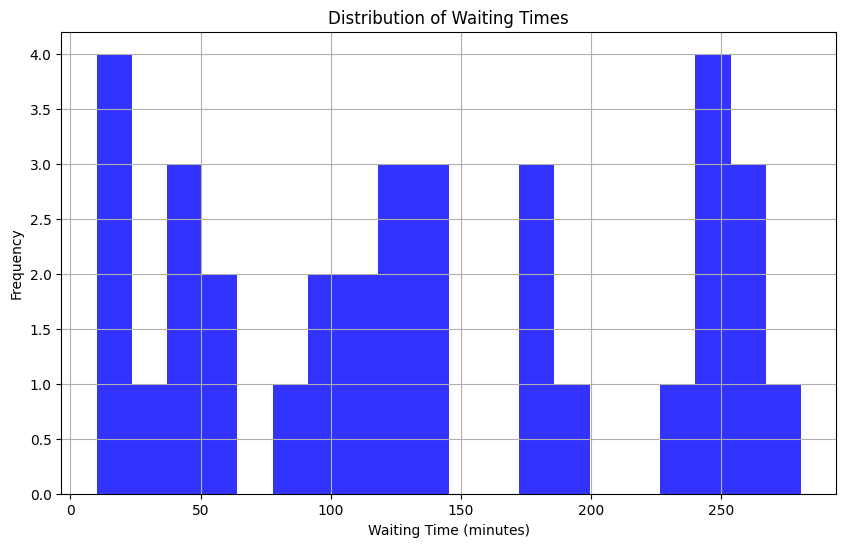

In [345]:
# Constants
MEAN_INTERARRIVAL = 10
CHECKIN_MIN = 6
CHECKIN_MAX = 12
TRIAGE_MIN = 3
TRIAGE_MAX = 15
TRIAGE_MODE = 5
CRITICAL_PROB = 0.4

# Global variables
num_doctors = 2

# Data collection
results = []
utilization_doctors = []
utilization_nurses = []

# Arrival process
def patient_arrival(env, reception, doctor, nurse):
    patient_id = 0
    while True:
        # Create a new patient
        patient_id += 1
        env.process(patient_process(env, patient_id, reception, doctor, nurse))

        # Sample time until next arrival
        interarrival_time = random.expovariate(1.0 / MEAN_INTERARRIVAL)
        yield env.timeout(interarrival_time)

# Patient process
def patient_process(env, patient_id, reception, doctor, nurse):
    global results

    # Check-in
    checkin_time = random.uniform(CHECKIN_MIN, CHECKIN_MAX)
    yield env.timeout(checkin_time)
    print(f"Patient {patient_id} checked-in at {env.now}")
    arrival_time = env.now

    # Triage
    triage_time = random.triangular(TRIAGE_MIN, TRIAGE_MAX, TRIAGE_MODE)
    yield env.timeout(triage_time)
    print(f"Patient {patient_id} triaged at {env.now}")
    token_time = env.now

    # Check critical condition
    critical = random.random() < CRITICAL_PROB

    # Request doctor/nurse
    if critical:
        with doctor.request() as req:
            yield req
            print(f"Patient {patient_id} sees a doctor at {env.now}")
            yield env.timeout(15)  # Treatment time for critical patients
            print(f"Patient {patient_id} treated by doctor at {env.now}")
            treatment_time = 15
    else:
        with nurse.request() as req:
            yield req
            print(f"Patient {patient_id} sees a nurse at {env.now}")
            yield env.timeout(10)  # Treatment time for non-critical patients
            print(f"Patient {patient_id} treated by nurse at {env.now}")
            treatment_time = 10

    # Calculate waiting time and treatment time
    waiting_time = env.now - (checkin_time + triage_time)

    # Record the results
    result = {
        'Patient ID': patient_id,
        'Service': 'Doctor' if critical else 'Nurse',
        'Arrival Time': arrival_time,
        'Token Time': token_time,
        'Service Start Time': env.now - treatment_time,
        'Service Stop Time': env.now,
        'Token Time (Secs)': token_time * 60,
        'Service Time (Mins)': treatment_time,
        'Wait Time (Mins)': waiting_time
    }
    results.append(result)

# Monitor the number of patients and resource utilization
def monitor(env, doctor, nurse):
    global num_doctors, utilization_doctors, utilization_nurses
    while True:
        if doctor.count == num_doctors and doctor.queue:
            num_doctors += 1
            print(f"Additional doctor summoned at {env.now}. Total doctors: {num_doctors}")
        elif num_doctors > 2 and doctor.count == 0 and not doctor.queue:
            num_doctors -= 1
            print(f"Doctor dismissed at {env.now}. Total doctors: {num_doctors}")

        utilization_doctors.append(doctor.count / num_doctors)
        utilization_nurses.append(nurse.count / 2)

        yield env.timeout(1)

# Set up simulation
env = simpy.Environment()

# Resources
reception = simpy.Resource(env, capacity=3)
doctor = simpy.Resource(env, capacity=num_doctors)
nurse = simpy.Resource(env, capacity=2)

# Start processes
env.process(patient_arrival(env, reception, doctor, nurse))
env.process(monitor(env, doctor, nurse))

# Run simulation
env.run(until=300)  # Run for 5 hours

# Create a DataFrame from the collected results
df = pd.DataFrame(results, columns=['Patient ID', 'Service', 'Arrival Time', 'Token Time',
                                    'Service Start Time', 'Service Stop Time', 'Token Time (Secs)',
                                    'Service Time (Mins)', 'Wait Time (Mins)'])

# Performance metric calculation
avg_waiting_time = df['Wait Time (Mins)'].mean()
avg_treatment_time = df['Service Time (Mins)'].mean()
doctor_utilization = np.mean(utilization_doctors)
nurse_utilization = np.mean(utilization_nurses)


# Print performance metrics
print(f"Average waiting time: {avg_waiting_time:.2f} minutes")
print(f"Average treatment time: {avg_treatment_time:.2f} minutes")
print(f"Doctor utilization: {doctor_utilization:.2%}")
print(f"Nurse utilization: {nurse_utilization:.2%}")

# Data visualization
plt.figure(figsize=(10, 6))
plt.hist(df['Wait Time (Mins)'], bins=20, alpha=0.8, color='blue')
plt.xlabel('Waiting Time (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Waiting Times')
plt.grid(True)
plt.show()

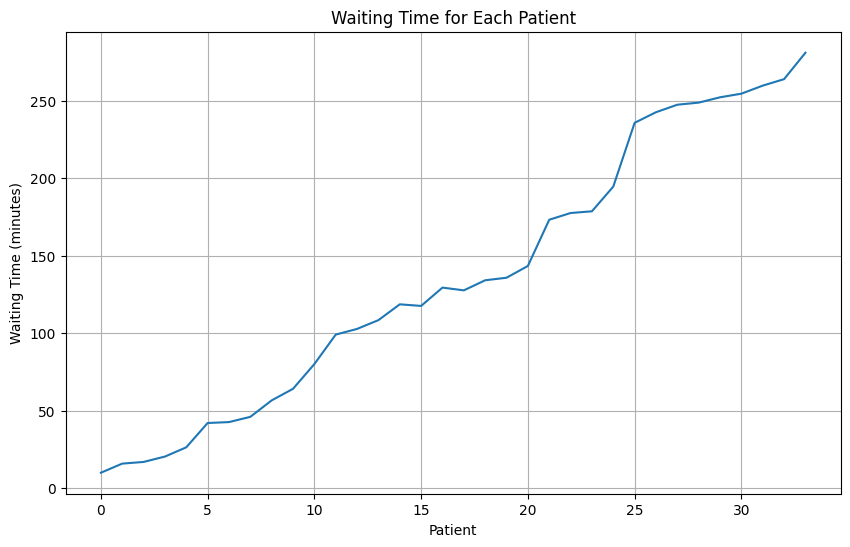

Simulation Report:

Average waiting time: 136.67 minutes



In [346]:
# Calculate average waiting time
avg_waiting_time = df['Wait Time (Mins)'].mean()

# Plot waiting time over time
plt.figure(figsize=(10, 6))
plt.plot(df['Wait Time (Mins)'])
plt.xlabel('Patient')
plt.ylabel('Waiting Time (minutes)')
plt.title('Waiting Time for Each Patient')
plt.grid(True)
plt.show()

# Print simulation report
simulation_report = f"Simulation Report:\n\n"
simulation_report += f"Average waiting time: {avg_waiting_time:.2f} minutes\n"
print(simulation_report)


# Verification and Validation


The emergency room simulation model was verified during the development process by printing and checking intermediate outputs. By reviewing the generated report for each run of the simulation, it was ensured that the service stop time of one patient did not overlap with the service start time of the next customer. Within the given time frame of the simulation, it was observed that an expected number of patients , approximately 32-22, were being served in each run. Additionally, other variables and values were tested during each run to ensure that there were no unrealistic or absurd results.

Validation of the simulation model for the emergency room scenario presented more challenges since there was no available dataset for comparison. However, the flow of patiants and the reported wait times closely resembled personal experiences in emergency room , which provided a basis for validation. Although the simulation was based on a hypothetical situation, the simulated wait times and the overall behavior of the system were deemed reasonable and aligned with real-world observations.
While validation against empirical data would have strengthened the reliability of the simulation, the model's outputs and behaviors were consistent with expectations and personal experiences. The simulation can be considered a useful tool for exploring and analyzing the emergency room scenario, providing insights and supporting decision making in the absence of real-world data.

In [347]:
# Display the DataFrame with improved formatting
styled_df = df.style.set_properties(**{'text-align': 'center'})
styled_df = styled_df.set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])

# Show the styled DataFrame
display(styled_df)


,Patient ID,Service,Arrival Time,Token Time,Service Start Time,Service Stop Time,Token Time (Secs),Service Time (Mins),Wait Time (Mins)
0,1,Nurse,7.895147,14.291125,14.291125,24.291125,857.467493,10,10.000000
1,2,Doctor,7.107478,12.328062,12.328062,27.328062,739.683690,15,15.872620
2,4,Nurse,18.381799,25.080854,25.080854,35.080854,1504.851215,10,16.952347
3,3,Doctor,16.327093,23.297101,23.297101,38.297101,1397.826048,15,20.418614
4,5,Nurse,24.221167,31.660643,31.660643,41.660643,1899.638550,10,26.381226
5,6,Doctor,33.933940,41.649656,41.649656,56.649656,2498.979336,15,42.062173
6,7,Nurse,39.470757,47.862859,47.862859,57.862859,2871.771530,10,42.655131
7,8,Nurse,43.001911,48.622759,48.622759,58.622759,2917.365524,10,46.037264
8,9,Nurse,57.653141,68.970324,68.970324,78.970324,4138.219461,10,56.653208
9,10,Nurse,62.798065,69.767587,69.767587,79.767587,4186.055194,10,64.123082


Bar Chart for Service Type

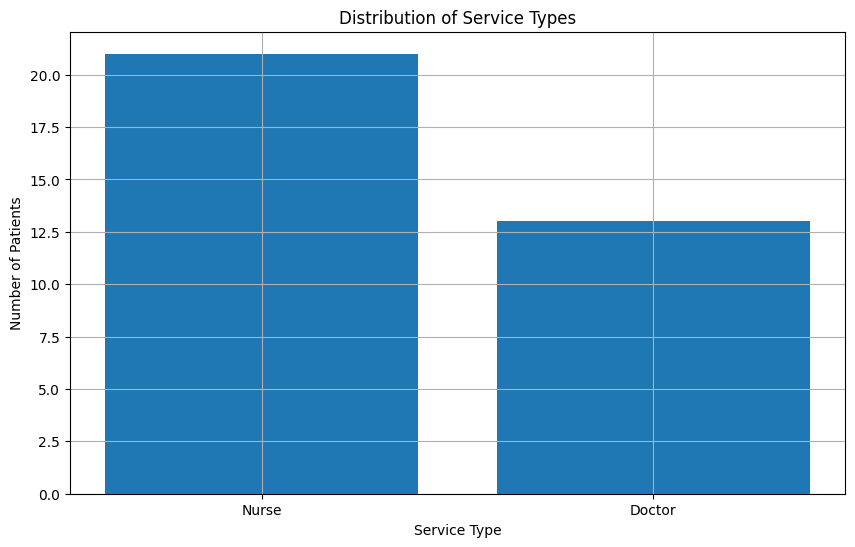

In [348]:
service_counts = df['Service'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(service_counts.index, service_counts.values)
plt.xlabel('Service Type')
plt.ylabel('Number of Patients')
plt.title('Distribution of Service Types')
plt.grid(True)
plt.show()


In [349]:
# Calculate performance metrics
avg_waiting_time = df['Wait Time (Mins)'].mean()
avg_treatment_time = df['Service Time (Mins)'].mean()
doctor_utilization = np.mean(utilization_doctors)
nurse_utilization = np.mean(utilization_nurses)

# Print performance metrics
print(f"Average waiting time: {avg_waiting_time:.2f} minutes")
print(f"Average treatment time: {avg_treatment_time:.2f} minutes")
print(f"Doctor utilization: {doctor_utilization:.2%}")
print(f"Nurse utilization: {nurse_utilization:.2%}")


Average waiting time: 136.67 minutes
Average treatment time: 11.91 minutes
Doctor utilization: 29.44%
Nurse utilization: 35.00%


Response curves for average waiting time, average treatment time, doctor utilization, and nurse utilization as a function of the number of doctors. Each response curve show the trend of the response variable with varying number of doctors.

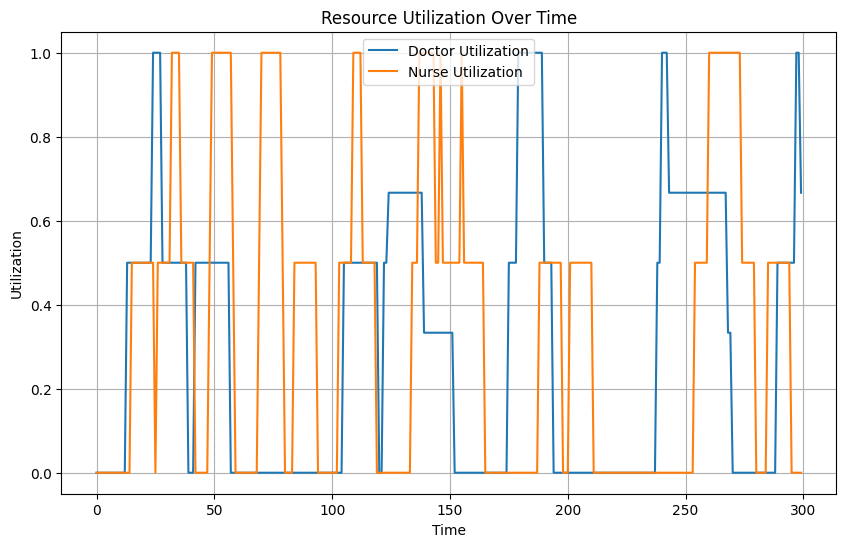

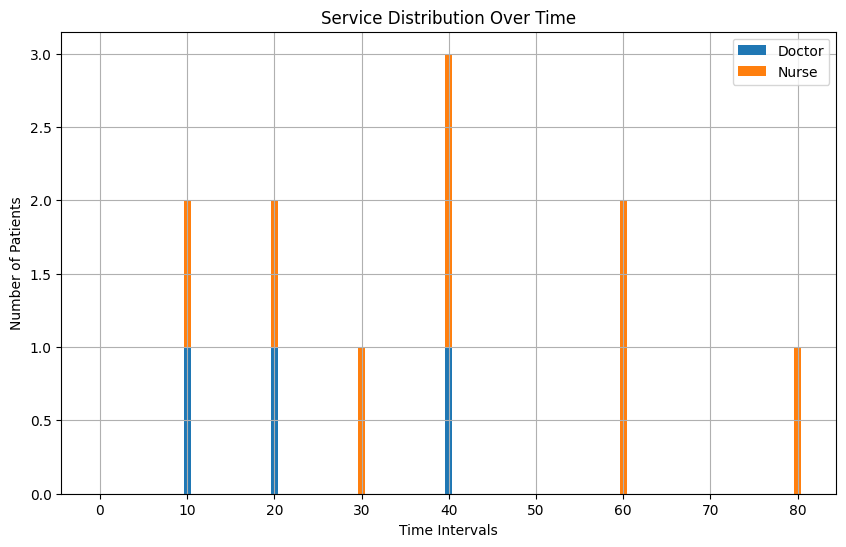

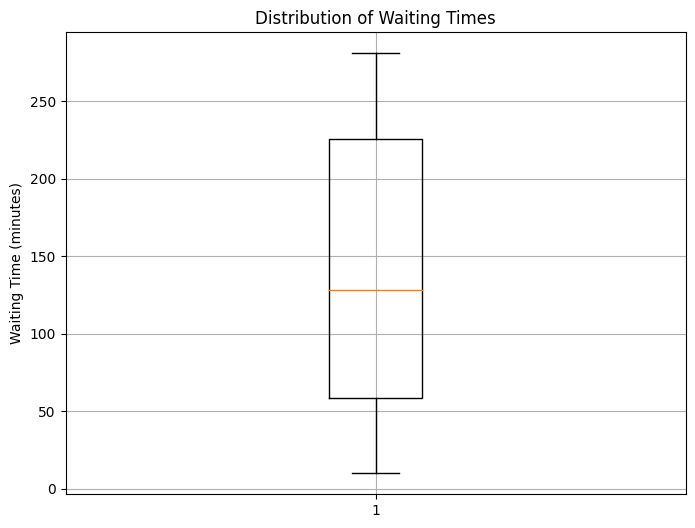

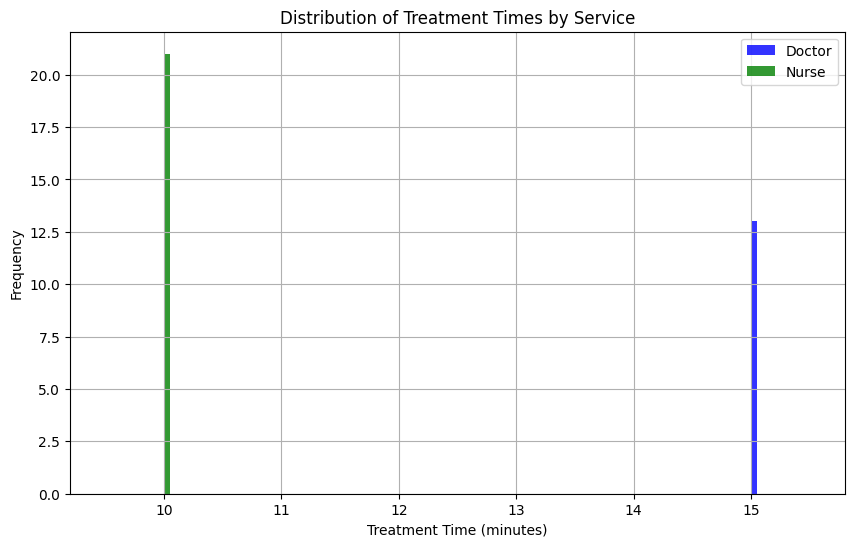

In [351]:
# Line Chart of Resource Utilization
plt.figure(figsize=(10, 6))
plt.plot(range(len(utilization_doctors)), utilization_doctors, label='Doctor Utilization')
plt.plot(range(len(utilization_nurses)), utilization_nurses, label='Nurse Utilization')
plt.xlabel('Time')
plt.ylabel('Utilization')
plt.title('Resource Utilization Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Stacked Bar Chart of Service Distribution
time_intervals = range(0, 100, 10)  # Customize the time intervals as needed
doctor_counts = df[df['Service'] == 'Doctor'].groupby(pd.cut(df['Service Start Time'], time_intervals)).size()
nurse_counts = df[df['Service'] == 'Nurse'].groupby(pd.cut(df['Service Start Time'], time_intervals)).size()

plt.figure(figsize=(10, 6))
plt.bar(time_intervals[:-1], doctor_counts, label='Doctor')
plt.bar(time_intervals[:-1], nurse_counts, bottom=doctor_counts, label='Nurse')
plt.xlabel('Time Intervals')
plt.ylabel('Number of Patients')
plt.title('Service Distribution Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Box Plot of Waiting Times
plt.figure(figsize=(8, 6))
plt.boxplot(df['Wait Time (Mins)'])
plt.ylabel('Waiting Time (minutes)')
plt.title('Distribution of Waiting Times')
plt.grid(True)
plt.show()

# Histogram of Treatment Times by Service
plt.figure(figsize=(10, 6))
plt.hist(df[df['Service'] == 'Doctor']['Service Time (Mins)'], bins=20, alpha=0.8, color='blue', label='Doctor')
plt.hist(df[df['Service'] == 'Nurse']['Service Time (Mins)'], bins=20, alpha=0.8, color='green', label='Nurse')
plt.xlabel('Treatment Time (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Treatment Times by Service')
plt.legend()
plt.grid(True)
plt.show()
# Animate the real-time visualization
ani = animation.FuncAnimation(fig, update, frames=range(0, 100), interval=100)
plt.show()

# conclusion

The simulation model developed for analyzing patient flow and resource allocation in an outpatient setting has provided valuable insights for healthcare administrators. By simulating the operations of a medical facility and considering key factors such as patient arrivals, triage, and treatment, the model has allowed us to evaluate important performance metrics. The results emphasize the significance of efficient triage and resource allocation based on patient severity. The verification and validation processes have ensured the model's accuracy and reliability. This simulation-based approach offers a data-driven decision-making tool to optimize patient flow, reduce waiting times, and maximize resource utilization. By utilizing the insights gained, medical facilities can make informed operational changes and enhance the quality of care in outpatient settings.